Załadowano train.csv: (3000888, 6)
Załadowano test.csv: (28512, 5)
Załadowano stores.csv: (54, 5)
Załadowano oil.csv: (1218, 2)
Załadowano holidays_events.csv: (350, 6)
Załadowano transactions.csv: (83488, 3)
--- Zakres dat w zbiorze treningowym ---
Start: 2013-01-01 00:00:00
Koniec: 2017-08-15 00:00:00
Liczba dni: 1688

--- Próbka danych (Train) ---


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



--- Informacje o typach ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


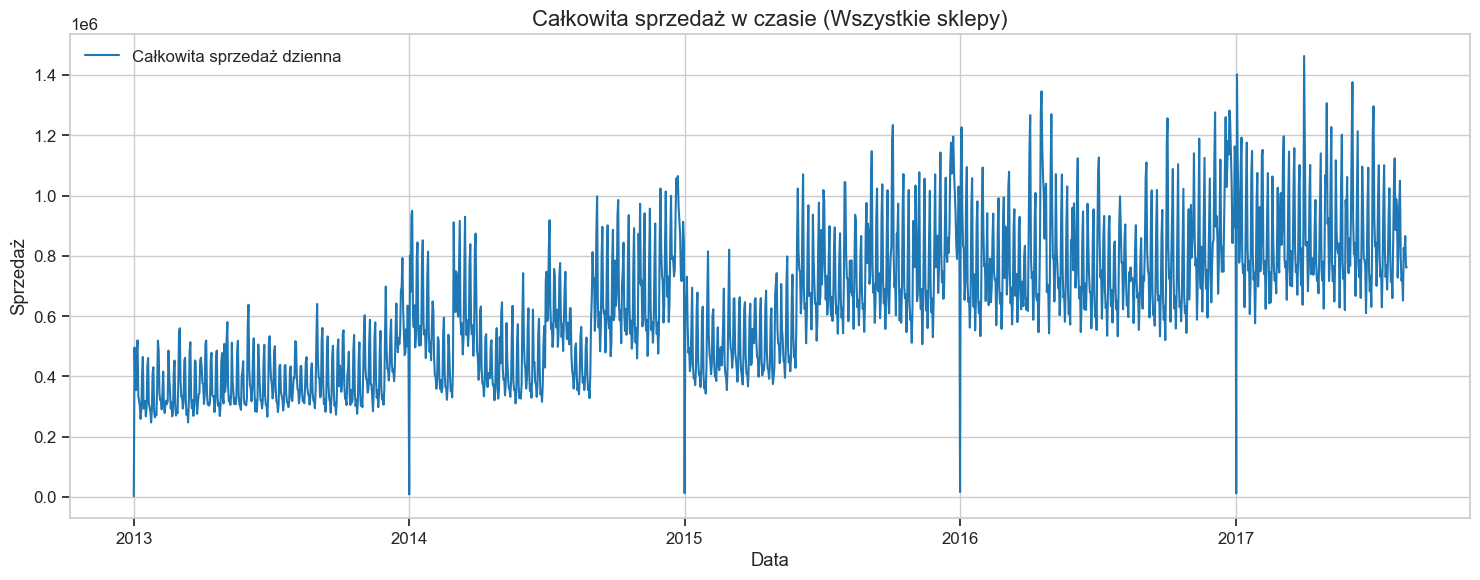

In [1]:
# %% [markdown]
# # Store Sales - Time Series Forecasting
# ## 1. Setup & Load Data
# Cel: Wczytanie danych, parsowanie dat i wstępny rzut oka na strukturę.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Ustawienia stylu wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

# %%
# Konfiguracja ścieżek (Windows)
# Używamy pathlib dla bezpieczeństwa ścieżek
BASE_DIR = Path(r"E:\Programowanie\.venv\Kaggle_Workshop\Store_Sales\data")

# Funkcja do ładowania danych z automatycznym parsowaniem dat
def load_data(file_name, parse_dates=['date']):
    path = BASE_DIR / file_name
    if not path.exists():
        raise FileNotFoundError(f"Nie znaleziono pliku: {path}")
    
    # Parsowanie daty przy odczycie oszczędza pamięć i czas
    df = pd.read_csv(path, parse_dates=parse_dates)
    print(f"Załadowano {file_name}: {df.shape}")
    return df

# %%
# Ładowanie głównych zbiorów
try:
    df_train = load_data('train.csv')
    df_test = load_data('test.csv')
    df_stores = load_data('stores.csv', parse_dates=None) # Tu nie ma kolumny date
    df_oil = load_data('oil.csv')
    df_holidays = load_data('holidays_events.csv')
    df_trans = load_data('transactions.csv')
except Exception as e:
    print(f"Błąd: {e}")

# %% [markdown]
# ## 2. Data Overview & Type Check
# Sprawdźmy zakresy dat i typy danych. W szeregach czasowych ciągłość dat jest kluczowa.

# %%
print("--- Zakres dat w zbiorze treningowym ---")
print(f"Start: {df_train.date.min()}")
print(f"Koniec: {df_train.date.max()}")
print(f"Liczba dni: {(df_train.date.max() - df_train.date.min()).days + 1}")

print("\n--- Próbka danych (Train) ---")
display(df_train.head())

print("\n--- Informacje o typach ---")
df_train.info()

# %% [markdown]
# ## 3. Quick Visualization
# Zobaczmy zagregowaną sprzedaż w czasie, aby ocenić ogólny trend.

# %%
# Agregacja sprzedaży po dacie (sumujemy sprzedaż ze wszystkich sklepów i kategorii)
daily_sales = df_train.groupby('date')['sales'].sum().reset_index()

# Wykres
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Całkowita sprzedaż dzienna', color='#1f77b4')
plt.title('Całkowita sprzedaż w czasie (Wszystkie sklepy)', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Sprzedaż')
plt.legend()
plt.tight_layout()
plt.show()

--- Dni z prawie zerową sprzedażą (Zamknięte sklepy?) ---


,date,sales



--- Czy brakuje jakichś dat w wierszach? ---
Brakujące daty: ['2013-12-25T00:00:00.000000000' '2014-12-25T00:00:00.000000000'
 '2015-12-25T00:00:00.000000000' '2016-12-25T00:00:00.000000000']
Uwaga: Wykres liniowy mógł to ukryć łącząc sąsiednie punkty!


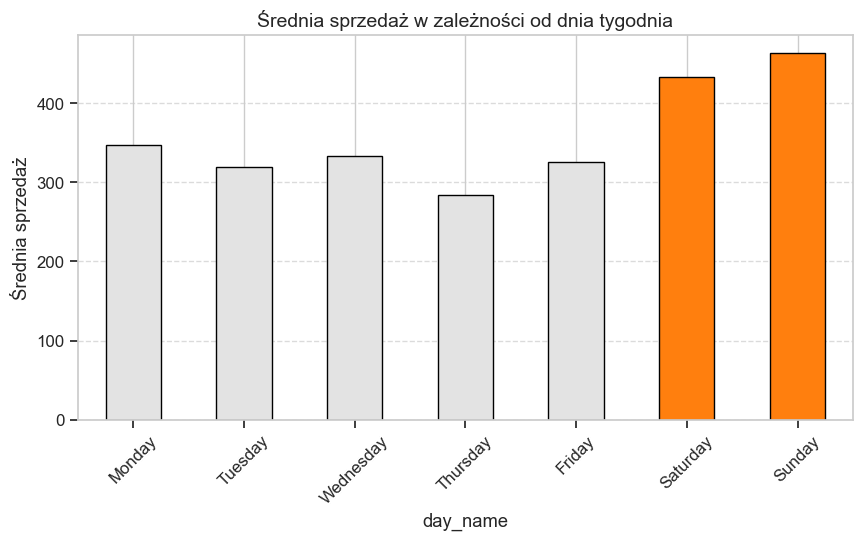

In [7]:
# %% [markdown]
# ## 4. Deep Dive: Anomalie i Ciągłość Czasu
# Sprawdzamy dni z podejrzanie niską sprzedażą oraz techniczne braki w datach.

# %%
# 1. Zidentyfikuj dni z bliską zeru sprzedażą (globalnie)
low_sales_days = daily_sales[daily_sales['sales'] < 100] # Próg arbitralny, bliski 0
print("--- Dni z prawie zerową sprzedażą (Zamknięte sklepy?) ---")
display(low_sales_days)

# 2. Sprawdź ciągłość dat (Missing Dates Check)
# Tworzymy pełny zakres dat od startu do końca
expected_dates = pd.date_range(start=df_train.date.min(), end=df_train.date.max())

# Porównujemy z datami, które faktycznie mamy w danych
actual_dates = df_train['date'].unique() # Unikalne daty w pliku
missing_dates = np.setdiff1d(expected_dates, actual_dates)

print(f"\n--- Czy brakuje jakichś dat w wierszach? ---")
if len(missing_dates) > 0:
    print(f"Brakujące daty: {missing_dates}")
    print("Uwaga: Wykres liniowy mógł to ukryć łącząc sąsiednie punkty!")
else:
    print("Brak luk w datach. Każdy dzień ma przynajmniej jeden wiersz.")

# %% [markdown]
# ## 5. Analiza Sezonowości Tygodniowej (Weekly Seasonality)
# Szeregi czasowe w handlu mają silny rytm tygodniowy. Sprawdźmy to.

# %%
# Dodajemy nazwę dnia tygodnia (0=Monday, 6=Sunday)
# Kopiujemy, żeby nie psuć oryginału na razie
df_eda = df_train.copy()
df_eda['day_of_week'] = df_eda['date'].dt.dayofweek
df_eda['day_name'] = df_eda['date'].dt.day_name()

# Agregacja średniej sprzedaży po dniu tygodnia
weekly_pattern = df_eda.groupby('day_name')['sales'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Wykres
plt.figure(figsize=(10, 5))
colors = ['#e3e3e3']*5 + ['#ff7f0e']*2 # Wyróżnijmy weekend kolorem
weekly_pattern.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Średnia sprzedaż w zależności od dnia tygodnia', fontsize=14)
plt.ylabel('Średnia sprzedaż')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Rozmiar siatki teoretycznej: 3008016 wierszy
Rozmiar oryginalny: 3000888 wierszy

Średnia sprzedaż w Boże Narodzenie po naprawie: 0.0


,date,store_nbr,family,sales,onpromotion
637956,2013-12-25,1,AUTOMOTIVE,0.0,0.0
637957,2013-12-25,1,BABY CARE,0.0,0.0
637958,2013-12-25,1,BEAUTY,0.0,0.0
637959,2013-12-25,1,BEVERAGES,0.0,0.0
637960,2013-12-25,1,BOOKS,0.0,0.0


--- Próbka danych po inżynierii cech ---


,date,store_nbr,family,sales,onpromotion,day_of_week,day,month,year,day_of_year,is_weekend,is_wage_day
1499891,2015-04-22,43,DAIRY,220.0,0.0,2,22,4,2015,112,0,0
1353687,2015-01-30,40,PLAYERS AND ELECTRONICS,0.0,0.0,4,30,1,2015,30,0,0
2717571,2017-03-06,1,LINGERIE,0.0,0.0,0,6,3,2017,65,0,0
175076,2013-04-09,21,FROZEN FOODS,0.0,0.0,1,9,4,2013,99,0,0
1308471,2015-01-05,22,LINGERIE,0.0,0.0,0,5,1,2015,5,0,0


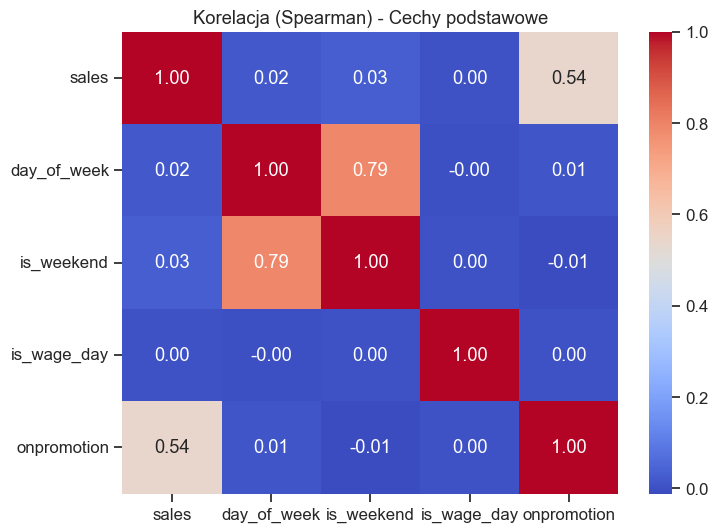

In [ ]:
# %% [markdown]
# ## 6. Data Cleaning: Uzupełnianie Brakujących Dat (Cartesian Product)
# Tworzymy pełną siatkę (Data x Sklep x Rodzina Produktów), aby ujawnić braki i wypełnić je zerami.

# %%
from itertools import product

# 1. Pobieramy unikalne wartości
unique_dates = pd.date_range(start=df_train.date.min(), end=df_train.date.max())
unique_stores = df_train.store_nbr.unique()
unique_families = df_train.family.unique()

# 2. Tworzymy siatkę (Iloczyn kartezjański)
# To wygeneruje wiersze dla każdego sklepu i produktu na każdy dzień (w tym 25 grudnia)
cartesian_product = product(unique_dates, unique_stores, unique_families)

# Tworzymy DataFrame z siatki
df_grid = pd.DataFrame(cartesian_product, columns=['date', 'store_nbr', 'family'])

print(f"Rozmiar siatki teoretycznej: {df_grid.shape[0]} wierszy")
print(f"Rozmiar oryginalny: {df_train.shape[0]} wierszy")

# 3. Łączymy (Merge) z oryginalnymi danymi
# Używamy left join, żeby zachować całą siatkę
df_train_full = df_grid.merge(df_train, on=['date', 'store_nbr', 'family'], how='left')

# 4. Wypełniamy braki (NaN) zerami
# Jeśli nie było wiersza w oryginale, to znaczy że sklep nie sprzedawał -> 0
df_train_full['sales'] = df_train_full['sales'].fillna(0)
df_train_full['onpromotion'] = df_train_full['onpromotion'].fillna(0)

# Usuwamy zbędną kolumnę id (stworzymy własny indeks jeśli trzeba)
if 'id' in df_train_full.columns:
    df_train_full = df_train_full.drop(columns=['id'])

# Sprawdzenie czy 25 grudnia już istnieje i ma zera
check_xmas = df_train_full[
    (df_train_full['date'].dt.month == 12) & 
    (df_train_full['date'].dt.day == 25)
]
print(f"\nŚrednia sprzedaż w Boże Narodzenie po naprawie: {check_xmas['sales'].mean()}")
display(check_xmas.head())

# %% [markdown]
# ## 7. Basic Feature Engineering: Cechy Kalendarzowe
# Zamieniamy daty na liczby zrozumiałe dla modelu ML.

# %%
def create_date_features(df):
    df = df.copy()
    
    # Podstawowe atrybuty daty
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    
    # Cechy biznesowe
    # Weekend (Sobota i Niedziela)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Ekwadorski system wypłat: 15-tego i ostatniego dnia miesiąca
    # Ludzie mają wtedy pieniądze -> sprzedaż rośnie
    df['is_wage_day'] = ((df['day'] == 15) | (df['date'].dt.is_month_end)).astype(int)
    
    return df

# Aplikujemy funkcję
df_train_features = create_date_features(df_train_full)

print("--- Próbka danych po inżynierii cech ---")
display(df_train_features.sample(5))

# Szybki check korelacji dla nowych cech
# Używamy metody spearman, bo zależności mogą nie być liniowe
corr_matrix = df_train_features[['sales', 'day_of_week', 'is_weekend', 'is_wage_day', 'onpromotion']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacja (Spearman) - Cechy podstawowe")
plt.show()

Zbiór treningowy: 2013-01-01 00:00:00 do 2017-07-31 00:00:00 (2981286 wierszy)
Zbiór walidacyjny: 2017-08-01 00:00:00 do 2017-08-15 00:00:00 (26730 wierszy)

--- Wynik Baseline (RMSLE) ---
RMSLE: 2.2281


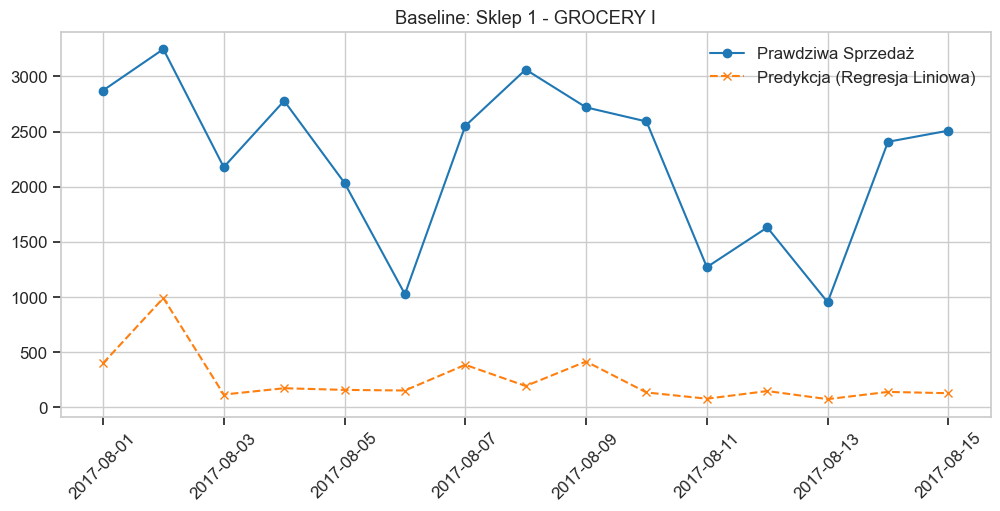

In [14]:
# %% [markdown]
# ## 8. Modeling: Time Series Split & Baseline
# Przygotowanie zbiorów treningowych i walidacyjnych oraz budowa modelu odniesienia (Linear Regression).

# %%
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error

# 1. Transformacja Logarytmiczna Zmiennej Celu
# Model będzie przewidywał logarytm sprzedaży, nie sprzedaż bezpośrednio.
# To automatycznie optymalizuje nas pod metrykę RMSLE.
df_train_features['sales_log'] = np.log1p(df_train_features['sales'])

# 2. Podział Chronologiczny (Time Split)
# Dane treningowe kończą się 2017-08-15.
# Zostawmy ostatnie 2 tygodnie (sierpień) jako zbiór walidacyjny (podobnie jak w Test Set na Kaggle).
split_date = '2017-07-31'

train_set = df_train_features[df_train_features['date'] <= split_date]
val_set = df_train_features[df_train_features['date'] > split_date]

print(f"Zbiór treningowy: {train_set['date'].min()} do {train_set['date'].max()} ({len(train_set)} wierszy)")
print(f"Zbiór walidacyjny: {val_set['date'].min()} do {val_set['date'].max()} ({len(val_set)} wierszy)")

# 3. Wybór cech (Features)
# Na start tylko to, co mamy: kalendarz + promocje
features = ['onpromotion', 'day_of_week', 'is_weekend', 'is_wage_day', 'day_of_year']
target = 'sales_log'

X_train = train_set[features]
y_train = train_set[target]

X_val = val_set[features]
y_val = val_set[target]

# 4. Trenowanie Baseline (Linear Regression)
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 5. Predykcja
y_pred_log = model_lr.predict(X_val)

# Musimy zamienić predykcje ujemne na 0 (log nie może być ujemny w sensie logicznym tutaj, ale model może zwrócić cokolwiek)
y_pred_log = np.maximum(y_pred_log, 0)

# Odkręcamy logarytm (expm1), żeby zobaczyć realne liczby sprzedaży
y_pred_real = np.expm1(y_pred_log)
y_val_real = np.expm1(y_val)

# 6. Ewaluacja (RMSLE)
# Skoro liczyliśmy RMSE na logarytmach, to jest to matematycznie tożsame z RMSLE na oryginale.
score = np.sqrt(mean_squared_error(y_val, y_pred_log))
print(f"\n--- Wynik Baseline (RMSLE) ---")
print(f"RMSLE: {score:.4f}")

# %% [markdown]
# ## 9. Wizualizacja Błędów
# Zobaczmy jak model radzi sobie na małym wycinku danych (jeden sklep, jedna kategoria).

# %%
# Wybieramy przykładowy sklep i kategorię do wizualizacji
sample_store = 1
sample_family = 'GROCERY I'

mask_val = (val_set['store_nbr'] == sample_store) & (val_set['family'] == sample_family)

# Pobieramy fragment danych walidacyjnych i odpowiadające im predykcje
sample_dates = val_set[mask_val]['date']
sample_actual = y_val_real[mask_val]

# Ponieważ y_pred_log to tablica numpy bez indeksu, musimy wyciągnąć odpowiednie indeksy
sample_indices = val_set.index[mask_val] 
# (Zakładając, że indeksy się nie zresetowały - w tym przypadku bezpieczniej użyć boolean mask na arrayu)
sample_preds = np.expm1(y_pred_log[val_set.reset_index().index[mask_val]]) # Trochę gimnastyki z indeksami

plt.figure(figsize=(12, 5))
plt.plot(sample_dates, sample_actual, label='Prawdziwa Sprzedaż', marker='o')
plt.plot(sample_dates, sample_preds, label='Predykcja (Regresja Liniowa)', linestyle='--', marker='x')
plt.title(f'Baseline: Sklep {sample_store} - {sample_family}')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Przykładowe mapowanie kategorii:
AUTOMOTIVE -> 0
BABY CARE -> 1
BEAUTY -> 2
BEVERAGES -> 3
BOOKS -> 4
Rozpoczynam trenowanie XGBoost...
[0]	validation_0-rmse:2.60760	validation_1-rmse:2.52699
[100]	validation_0-rmse:1.03012	validation_1-rmse:0.85074
[122]	validation_0-rmse:1.00557	validation_1-rmse:0.84834

--- Wynik XGBoost (RMSLE) ---
Poprzednio (Linear): 2.2281
Teraz (XGBoost):     0.8432


C:\Users\User\AppData\Local\Temp\ipykernel_30424\374844763.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='Importance', y='Feature', palette='viridis')


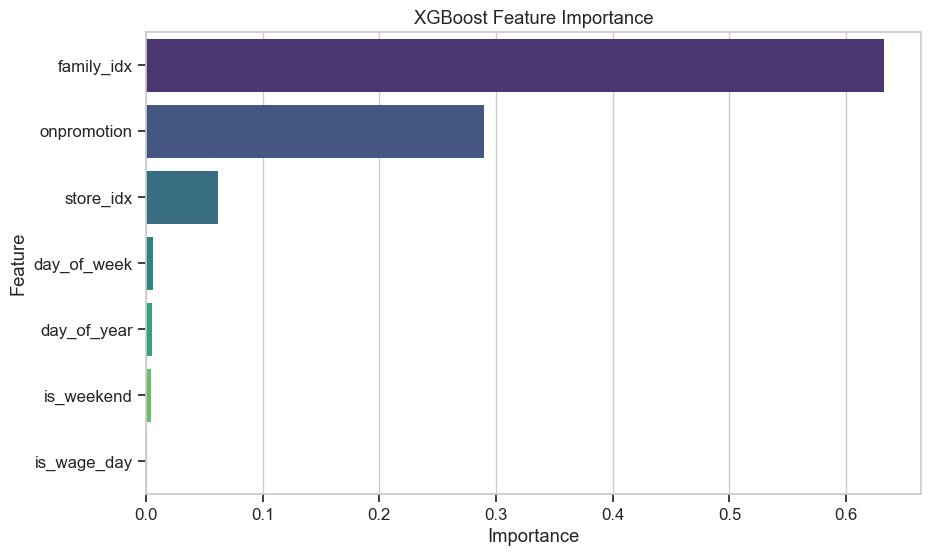

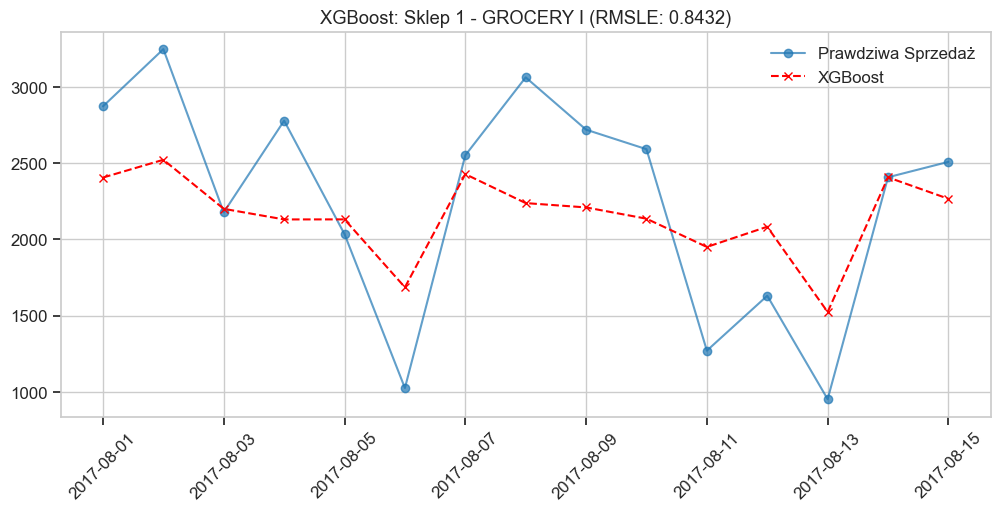

In [15]:
# %% [markdown]
# ## 10. Feature Engineering Phase 2: Label Encoding
# Musimy nauczyć model rozróżniać sklepy i produkty. XGBoost lubi liczby.

# %%
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# Kopiujemy dane, żeby nie psuć poprzednich kroków
df_ml = df_train_features.copy()

# Enkodery
le_family = LabelEncoder()
le_store = LabelEncoder()

# Zamiana tekstu na liczby
df_ml['family_idx'] = le_family.fit_transform(df_ml['family'])
df_ml['store_idx'] = le_store.fit_transform(df_ml['store_nbr'])

print("Przykładowe mapowanie kategorii:")
# Pokażmy 5 pierwszych klas
for i, item in enumerate(le_family.classes_[:5]):
    print(f"{item} -> {i}")

# %% [markdown]
# ## 11. XGBoost Model Training
# Przechodzimy na algorytm gradient boosting.

# %%
# Aktualizacja listy cech - dodajemy ID sklepu i rodziny
features_xgb = [
    'onpromotion', 
    'day_of_week', 'is_weekend', 'is_wage_day', 'day_of_year',
    'family_idx', 'store_idx'  # <--- KLUCZOWE NOWE CECHY
]

# Ponowny podział na trening i walidację (na nowych danych df_ml)
train_set_xgb = df_ml[df_ml['date'] <= split_date]
val_set_xgb = df_ml[df_ml['date'] > split_date]

X_train_xgb = train_set_xgb[features_xgb]
y_train_xgb = train_set_xgb['sales_log']

X_val_xgb = val_set_xgb[features_xgb]
y_val_xgb = val_set_xgb['sales_log']

# Konfiguracja modelu XGBoost
# Używamy parametrów startowych, bez głębokiego tuningu
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,        # Dużo drzew
    learning_rate=0.05,       # Wolniejsza nauka = większa precyzja
    max_depth=10,             # Głębsze drzewa (bo mamy dużo interakcji)
    subsample=0.8,            # Zapobiega overfittingowi
    colsample_bytree=0.8,
    early_stopping_rounds=50, # Zatrzymaj, jak przestanie się uczyć
    n_jobs=-1,                # Użyj wszystkich rdzeni procesora
    random_state=42
)

# Trenowanie
# Uwaga: eval_set pozwala modelowi sprawdzać błąd na bieżąco
print("Rozpoczynam trenowanie XGBoost...")
model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)],
    verbose=100  # Pokaż logi co 100 drzew
)

# %% [markdown]
# ## 12. Ewaluacja XGBoost
# Sprawdźmy, o ile poprawiliśmy wynik 2.22.

# %%
# Predykcja
y_pred_xgb_log = model_xgb.predict(X_val_xgb)
y_pred_xgb_log = np.maximum(y_pred_xgb_log, 0) # Zabezpieczenie przed ujemnymi

# Wynik RMSLE
score_xgb = np.sqrt(mean_squared_error(y_val_xgb, y_pred_xgb_log))
print(f"\n--- Wynik XGBoost (RMSLE) ---")
print(f"Poprzednio (Linear): 2.2281")
print(f"Teraz (XGBoost):     {score_xgb:.4f}")

# %% [markdown]
# ## 13. Analiza Ważności Cech (Feature Importance)
# Co jest najważniejsze dla modelu?

# %%
plt.figure(figsize=(10, 6))
# XGBoost ma wbudowaną metodę plot_importance, ale zrobimy to ładniej w seaborn
importance = pd.DataFrame({
    'Feature': features_xgb,
    'Importance': model_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=importance, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importance')
plt.show()

# %% [markdown]
# ## 14. Wizualizacja: Sklep vs Predykcja (Poprawiona)
# Sprawdźmy ten sam sklep co wcześniej.

# %%
# Odkręcamy logarytm dla wykresu
y_pred_xgb_real = np.expm1(y_pred_xgb_log)
y_val_real = np.expm1(y_val_xgb)

# Filtrowanie dla tego samego sklepu co wcześniej
mask_val = (val_set_xgb['store_nbr'] == sample_store) & (val_set_xgb['family'] == sample_family)
sample_dates = val_set_xgb[mask_val]['date']
sample_actual = y_val_real[mask_val]
sample_preds_xgb = y_pred_xgb_real[val_set_xgb.reset_index().index[mask_val]]

plt.figure(figsize=(12, 5))
plt.plot(sample_dates, sample_actual, label='Prawdziwa Sprzedaż', marker='o', alpha=0.7)
plt.plot(sample_dates, sample_preds_xgb, label='XGBoost', linestyle='--', marker='x', color='red')
plt.title(f'XGBoost: Sklep {sample_store} - {sample_family} (RMSLE: {score_xgb:.4f})')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [16]:
# %% [markdown]
# ## 15. Feature Engineering Phase 3: Lags & Rolling Statistics
# Dodajemy pamięć do modelu. Używamy shift(16), aby uniknąć wycieku danych w teście.

# %%
def create_lag_features(df):
    df = df.copy()
    
    # Sortujemy, żeby shifty działały chronologicznie
    df = df.sort_values(['store_nbr', 'family', 'date'])
    
    # Grupowanie - musimy liczyć opóźnienia OSOBNO dla każdego sklepu i produktu
    # Używamy transform, aby zachować wymiar indeksu
    groupby_obj = df.groupby(['store_nbr', 'family'])['sales_log']
    
    # 1. Lag 16 (Co działo się 16 dni temu? - bezpieczne dla całego horyzontu testu)
    df['lag_16'] = groupby_obj.shift(16)
    
    # 2. Lag 21 (Co działo się 3 tygodnie temu? - wyłapuje cykl tygodniowy)
    df['lag_21'] = groupby_obj.shift(21)
    
    # 3. Lag 365 (Co działo się rok temu?)
    df['lag_365'] = groupby_obj.shift(365)
    
    # 4. Rolling Mean (Średnia ruchoma)
    # Średnia z 14 dni, ale przesunięta o 16 dni w tył (żebyśmy ją znali w momencie predykcji)
    df['rolling_mean_14'] = groupby_obj.transform(lambda x: x.shift(16).rolling(window=14).mean())
    
    # 5. Rolling Std (Odchylenie standardowe - zmienność)
    df['rolling_std_14'] = groupby_obj.transform(lambda x: x.shift(16).rolling(window=14).std())
    
    return df

print("Generowanie cech opóźnionych (może to chwilę potrwać)...")
df_ml_lags = create_lag_features(df_ml)

# Usuwamy wiersze z NaN, które powstały przez shift (początek historii)
# To nam utnie pierwszy rok danych, ale to OK, bo i tak mamy dużo
df_ml_lags = df_ml_lags.dropna()

print(f"Nowy rozmiar danych: {df_ml_lags.shape}")
display(df_ml_lags[['date', 'store_nbr', 'family', 'sales', 'lag_16', 'rolling_mean_14']].tail())

Generowanie cech opóźnionych (może to chwilę potrwać)...
Nowy rozmiar danych: (2357586, 20)


,date,store_nbr,family,sales,lag_16,rolling_mean_14
3000755,2017-08-11,54,SEAFOOD,0.0,1.386294,1.067558
3002537,2017-08-12,54,SEAFOOD,1.0,1.098612,1.146030
3004319,2017-08-13,54,SEAFOOD,2.0,1.609438,1.260990
3006101,2017-08-14,54,SEAFOOD,0.0,1.609438,1.297477
3007883,2017-08-15,54,SEAFOOD,3.0,1.609438,1.284454


Rozpoczynam trenowanie XGBoost (Advanced)...
[0]	validation_0-rmse:2.62506	validation_1-rmse:2.52166
[100]	validation_0-rmse:0.70729	validation_1-rmse:0.54564
[200]	validation_0-rmse:0.55598	validation_1-rmse:0.42692
[300]	validation_0-rmse:0.51648	validation_1-rmse:0.42316
[400]	validation_0-rmse:0.49258	validation_1-rmse:0.42217
[416]	validation_0-rmse:0.48926	validation_1-rmse:0.42235

--- Wynik XGBoost Advanced (RMSLE) ---
Baseline (Linear):  2.2281
XGBoost (Basic):    0.8432
XGBoost (Lags):     0.4218


C:\Users\User\AppData\Local\Temp\ipykernel_30424\78032671.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_adv, x='Importance', y='Feature', palette='magma')


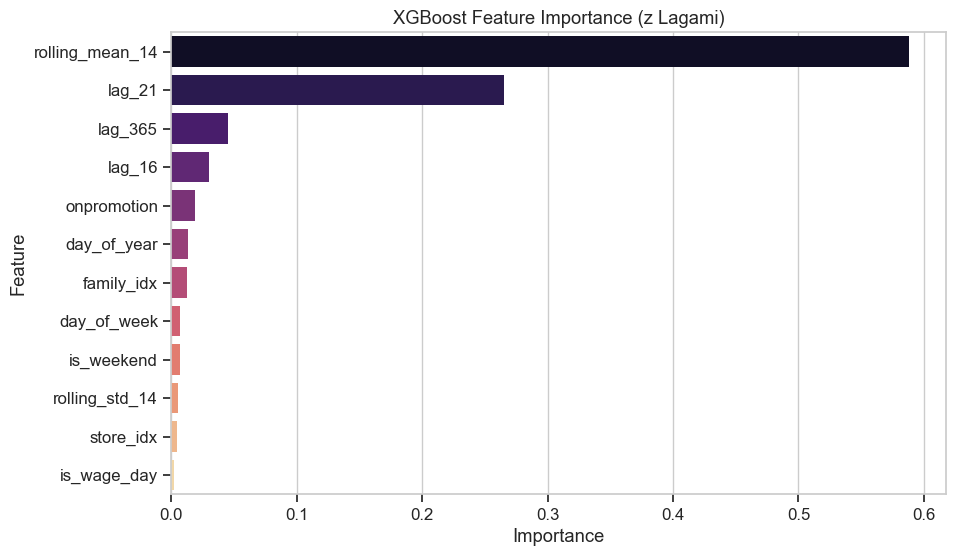

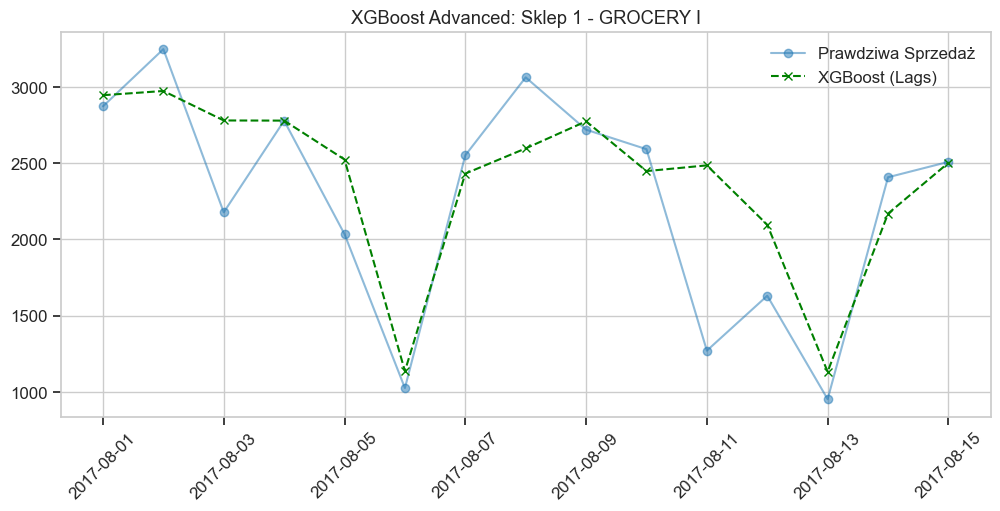

In [17]:
# %% [markdown]
# ## 16. Retraining XGBoost with Time Features
# Sprawdzamy, czy informacja o przeszłości poprawi wynik.

# %%
# Aktualizacja listy cech
features_advanced = [
    'onpromotion', 
    'day_of_week', 'is_weekend', 'is_wage_day', 'day_of_year',
    'family_idx', 'store_idx',
    'lag_16', 'lag_21', 'lag_365', 'rolling_mean_14', 'rolling_std_14' # <--- NOWE
]

# Podział danych (używamy tej samej daty splitu)
train_set_adv = df_ml_lags[df_ml_lags['date'] <= split_date]
val_set_adv = df_ml_lags[df_ml_lags['date'] > split_date]

X_train_adv = train_set_adv[features_advanced]
y_train_adv = train_set_adv['sales_log']

X_val_adv = val_set_adv[features_advanced]
y_val_adv = val_set_adv['sales_log']

# Model
model_xgb_adv = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.02,    # Zmniejszamy learning rate, bo mamy więcej cech
    max_depth=12,          # Głębiej, żeby wyłapać relacje czasowe
    subsample=0.7,
    colsample_bytree=0.7,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

print("Rozpoczynam trenowanie XGBoost (Advanced)...")
model_xgb_adv.fit(
    X_train_adv, y_train_adv,
    eval_set=[(X_train_adv, y_train_adv), (X_val_adv, y_val_adv)],
    verbose=100
)

# Ewaluacja
y_pred_adv_log = model_xgb_adv.predict(X_val_adv)
y_pred_adv_log = np.maximum(y_pred_adv_log, 0)

score_adv = np.sqrt(mean_squared_error(y_val_adv, y_pred_adv_log))
print(f"\n--- Wynik XGBoost Advanced (RMSLE) ---")
print(f"Baseline (Linear):  2.2281")
print(f"XGBoost (Basic):    {score_xgb:.4f}")
print(f"XGBoost (Lags):     {score_adv:.4f}")

# Wykres ważności cech
plt.figure(figsize=(10, 6))
importance_adv = pd.DataFrame({
    'Feature': features_advanced,
    'Importance': model_xgb_adv.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=importance_adv, x='Importance', y='Feature', palette='magma')
plt.title('XGBoost Feature Importance (z Lagami)')
plt.show()

# Wizualizacja dla tego samego sklepu
y_pred_adv_real = np.expm1(y_pred_adv_log)
y_val_real = np.expm1(y_val_adv)

# Filtrowanie
mask_val = (val_set_adv['store_nbr'] == sample_store) & (val_set_adv['family'] == sample_family)
sample_dates = val_set_adv[mask_val]['date']
sample_actual = y_val_real[mask_val]
sample_preds_adv = y_pred_adv_real[val_set_adv.reset_index().index[mask_val]]

plt.figure(figsize=(12, 5))
plt.plot(sample_dates, sample_actual, label='Prawdziwa Sprzedaż', marker='o', alpha=0.5)
plt.plot(sample_dates, sample_preds_adv, label='XGBoost (Lags)', linestyle='--', marker='x', color='green')
plt.title(f'XGBoost Advanced: Sklep {sample_store} - {sample_family}')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [19]:
# %% [markdown]
# ## 17. Final Pipeline: Full Training & Submission (POPRAWIONE)
# Łączymy dane, generujemy cechy dla Testu i trenujemy ostateczny model.

# %%
# 1. Wczytanie danych testowych
df_test = load_data('test.csv')
print(f"Dane testowe: {df_test.shape}")

# 2. Przygotowanie "Węża Danych" (Concatenation)
# POPRAWKA: Nie pobieramy 'id' z train, bo go usunęliśmy w kroku 6.
# Model nie potrzebuje ID do nauki.
train_subset = df_train_full[['date', 'store_nbr', 'family', 'sales', 'onpromotion']].copy()

# Test musi mieć 'id', bo jest potrzebne do pliku wynikowego
test_subset = df_test[['id', 'date', 'store_nbr', 'family', 'onpromotion']].copy()
test_subset['sales'] = np.nan # W teście nie znamy sprzedaży

# Łączymy
# Pandas automatycznie dopasuje kolumny. 
# Kolumna 'id' będzie miała wartości dla wierszy z testu, a NaN dla wierszy z treningu.
df_concat = pd.concat([train_subset, test_subset], axis=0).reset_index(drop=True)
df_concat['sales'] = df_concat['sales'].fillna(0) 

# 3. Feature Engineering na całości
# A. Cechy daty
df_concat = create_date_features(df_concat)

# B. Label Encoding
# Używamy tych samych instancji encodera co wcześniej
df_concat['family_idx'] = le_family.fit_transform(df_concat['family'])
df_concat['store_idx'] = le_store.fit_transform(df_concat['store_nbr'])

# C. Logarytm celu
df_concat['sales_log'] = np.log1p(df_concat['sales'])

# D. Lagi i Rolling
print("Generowanie cech opóźnionych dla całości (cierpliwości)...")
df_concat_lags = create_lag_features(df_concat)

# 4. Rozdzielenie z powrotem na Train i Test
test_start_date = '2017-08-16'

final_train = df_concat_lags[df_concat_lags['date'] < test_start_date]
final_test = df_concat_lags[df_concat_lags['date'] >= test_start_date]

# Usuwamy NaN z treningu (początek historii)
final_train = final_train.dropna(subset=features_advanced) 
# Uwaga: dropna tylko na cechach, nie usuwamy całego wiersza jeśli ID jest NaN (bo w train ID jest zawsze NaN)

print(f"Final Train shape: {final_train.shape}")
print(f"Final Test shape: {final_test.shape}")

# 5. Trening na CAŁYM zbiorze
X_train_full = final_train[features_advanced]
y_train_full = final_train['sales_log']

X_test_final = final_test[features_advanced]

print("Trenowanie ostatecznego modelu na pełnych danych...")
final_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=12,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X_train_full, y_train_full, verbose=False)

# 6. Predykcja dla Testu
predictions_log = final_model.predict(X_test_final)
predictions_log = np.maximum(predictions_log, 0) # Bez ujemnych
predictions_real = np.expm1(predictions_log) # Odkręcamy logarytm

# 7. Tworzenie pliku submission.csv
# Teraz zadziała, bo final_test pochodzi od test_subset, który miał 'id'
submission = pd.DataFrame({
    'id': final_test['id'].astype(int), # Upewniamy się, że ID to int
    'sales': predictions_real
})

# Zapis do pliku
output_path = BASE_DIR / 'submission.csv'
submission.to_csv(output_path, index=False)
print(f"✅ Plik zapisano: {output_path}")
print("Gotowy do wysłania na Kaggle!")

# Szybki podgląd
display(submission.head())

Załadowano test.csv: (28512, 5)
Dane testowe: (28512, 5)
Generowanie cech opóźnionych dla całości (cierpliwości)...
Final Train shape: (2357586, 21)
Final Test shape: (28512, 21)
Trenowanie ostatecznego modelu na pełnych danych...
✅ Plik zapisano: E:\Programowanie\.venv\Kaggle_Workshop\Store_Sales\data\submission.csv
Gotowy do wysłania na Kaggle!


,id,sales
3008016,3000888,4.370598
3009798,3002670,3.847366
3011580,3004452,3.716352
3013362,3006234,3.662672
3015144,3008016,1.495557
